In [1]:
import pandas as pd
import os
import sys
import math
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws, filter_counties
from scripts.utils.write_metadata import append_metadata

In [2]:
evap_stress_link = 's3://ca-climate-index/2b_reproject/natural_systems/agricultural_productivity_conservation/usda_nasa/evaporative_stress_ca_reproject.zarr/'

In [3]:
ds_zarr = xr.open_zarr(evap_stress_link)
ds_zarr

<xarray.Dataset>
Dimensions:      (time: 418, lat: 191, lon: 208)
Coordinates:
  * lat          (lat) float64 42.02 41.97 41.92 41.87 ... 32.62 32.57 32.52
  * lon          (lon) float64 -124.5 -124.4 -124.4 ... -114.2 -114.2 -114.1
  * time         (time) datetime64[ns] 2015-01-01 2015-01-08 ... 2022-12-25
Data variables:
    esi          (time, lat, lon) float32 dask.array<chunksize=(418, 191, 208), meta=np.ndarray>
    spatial_ref  int64 ...

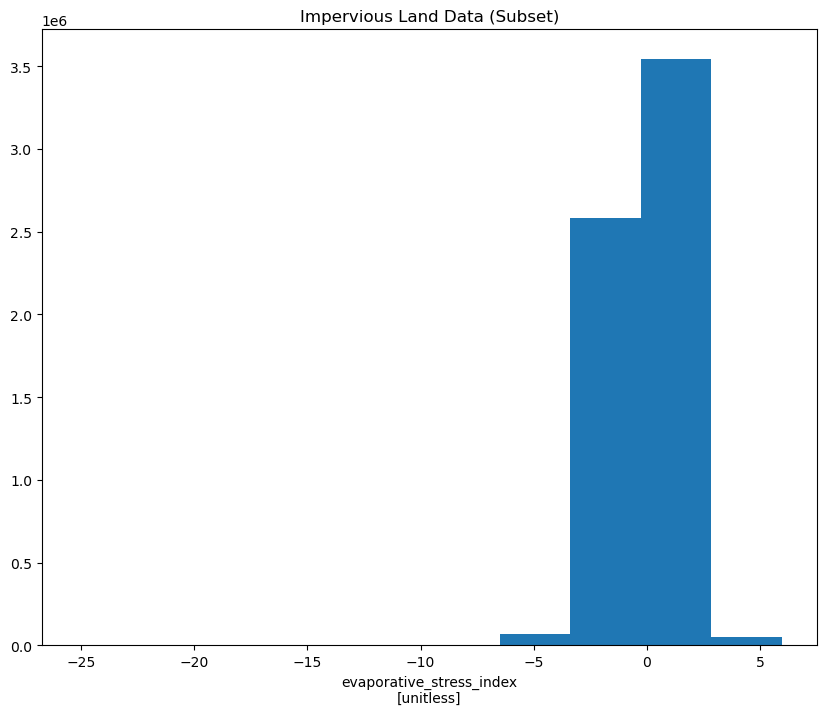

In [6]:
# Select a small subset of data for quick visualization
data_var_subset = ds_zarr['esi']

# Plot the subset
plt.figure(figsize=(10, 8))
data_var_subset.plot()
plt.title('Impervious Land Data (Subset)')
plt.show()

In [7]:
df = data_var_subset.to_dataframe().reset_index()

,time,lat,lon,esi
0,2015-01-01,42.025,-124.475,NaN
1,2015-01-01,42.025,-124.425,NaN
2,2015-01-01,42.025,-124.375,NaN
3,2015-01-01,42.025,-124.325,NaN
4,2015-01-01,42.025,-124.275,NaN
...,...,...,...,...
16606299,2022-12-25,32.525,-114.325,NaN
16606300,2022-12-25,32.525,-114.275,NaN
16606301,2022-12-25,32.525,-114.225,NaN
16606302,2022-12-25,32.525,-114.175,NaN


In [8]:
unique_esi_entries = df['esi'].nunique()
print(f'There are {unique_esi_entries} unique entries in the esi column.')

There are 5934152 unique entries in the esi column.


In [15]:
# Create geometry column from coordinates
geometry = [Point(xy) for xy in zip(df['lat'], df['lon'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

In [18]:
gdf.set_crs(epsg=3857, inplace=True)

,time,lat,lon,esi,geometry
0,2015-01-01,42.025,-124.475,NaN,POINT (42.025 -124.475)
1,2015-01-01,42.025,-124.425,NaN,POINT (42.025 -124.425)
2,2015-01-01,42.025,-124.375,NaN,POINT (42.025 -124.375)
3,2015-01-01,42.025,-124.325,NaN,POINT (42.025 -124.325)
4,2015-01-01,42.025,-124.275,NaN,POINT (42.025 -124.275)
...,...,...,...,...,...
16606299,2022-12-25,32.525,-114.325,NaN,POINT (32.525 -114.325)
16606300,2022-12-25,32.525,-114.275,NaN,POINT (32.525 -114.275)
16606301,2022-12-25,32.525,-114.225,NaN,POINT (32.525 -114.225)
16606302,2022-12-25,32.525,-114.175,NaN,POINT (32.525 -114.175)


In [9]:
# read in CA census tiger file
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)

In [19]:
# Check the current CRS of the GeoDataFrame
print("gdf CRS:", gdf.crs)

# Load your California boundaries GeoDataFrame (ca_boundaries)
# ca_boundaries = gpd.read_file('path_to_ca_boundaries_file')

# Check the current CRS of the California boundaries GeoDataFrame
print("ca_boundaries CRS:", ca_boundaries.crs)

# If they have different CRS, transform one to match the other
# For example, if you want to transform gdf to match ca_boundaries' CRS
if gdf.crs != ca_boundaries.crs:
    ca_boundaries = ca_boundaries.to_crs(gdf.crs)

# Now both GeoDataFrames should have the same CRS
print("Transformed ca_boundaries CRS:", gdf.crs)

gdf CRS: EPSG:3857
ca_boundaries CRS: EPSG:4269
Transformed gdf CRS: EPSG:3857


In [24]:
ca_boundaries_filtered = ca_boundaries[['GEOID', 'geometry']]

In [25]:
gdf

,time,lat,lon,esi,geometry
0,2015-01-01,42.025,-124.475,NaN,POINT (42.025 -124.475)
1,2015-01-01,42.025,-124.425,NaN,POINT (42.025 -124.425)
2,2015-01-01,42.025,-124.375,NaN,POINT (42.025 -124.375)
3,2015-01-01,42.025,-124.325,NaN,POINT (42.025 -124.325)
4,2015-01-01,42.025,-124.275,NaN,POINT (42.025 -124.275)
...,...,...,...,...,...
16606299,2022-12-25,32.525,-114.325,NaN,POINT (32.525 -114.325)
16606300,2022-12-25,32.525,-114.275,NaN,POINT (32.525 -114.275)
16606301,2022-12-25,32.525,-114.225,NaN,POINT (32.525 -114.225)
16606302,2022-12-25,32.525,-114.175,NaN,POINT (32.525 -114.175)


In [31]:
unique_esi_entries = gdf['esi'].nunique()
print(f'There are {unique_esi_entries} unique entries in the esi column.')

There are 5934152 unique entries in the esi column.


In [33]:
gdf.esi.min()

-25.1787166595459

In [38]:
merged_gdf = gpd.sjoin_nearest(
    ca_boundaries_filtered, 
    gdf, 
    how="inner", distance_col="distances", 
    max_distance=5000)

# Verify the merged GeoDataFrame
print(merged_gdf.head())

Empty GeoDataFrame
Columns: [GEOID, geometry, index_right, time, lat, lon, esi, distances]
Index: []


In [39]:
merged_gdf

,GEOID,geometry,index_right,time,lat,lon,esi,distances


In [29]:
unique_esi_entries = merged_gdf['esi'].nunique()
print(f'There are {unique_esi_entries} unique entries in the esi column.')

There are 0 unique entries in the esi column.
